### Automated anomaly detection using PyOD and Auto-Sklearn
Successive Halving algorithm for search

In [1]:
# Imports
import os, sys
import pandas as pd
from matplotlib import pyplot as plt
from datetime import timedelta as td
from sklearn.model_selection import train_test_split, PredefinedSplit, StratifiedShuffleSplit
from autosklearn.pipeline.components.classification import add_classifier
from autosklearn.classification import AutoSklearnClassifier
from autosklearn.metrics import roc_auc, average_precision
p = os.path.abspath('..')
sys.path.insert(1, p)
from utils import import_dataset, add_pyod_models_to_pipeline, balanced_split, get_metric_result
# Add models to Auto-Sklearn
add_pyod_models_to_pipeline()

In [2]:
import autosklearn.pipeline.components.data_preprocessing
from autosklearn.pipeline.components.base import AutoSklearnPreprocessingAlgorithm
from autosklearn.pipeline.constants import SPARSE, DENSE, UNSIGNED_DATA, INPUT
from ConfigSpace.configuration_space import ConfigurationSpace

class NoPreprocessing(AutoSklearnPreprocessingAlgorithm):

    def __init__(self, **kwargs):
        """ This preprocessors does not change the data """
        # Some internal checks makes sure parameters are set
        for key, val in kwargs.items():
            setattr(self, key, val)

    def fit(self, X, Y=None):
        return self

    def transform(self, X):
        return X

    @staticmethod
    def get_properties(dataset_properties=None):
        return {
            'shortname': 'NoPreprocessing',
            'name': 'NoPreprocessing',
            'handles_regression': True,
            'handles_classification': True,
            'handles_multiclass': True,
            'handles_multilabel': True,
            'handles_multioutput': True,
            'is_deterministic': True,
            'input': (SPARSE, DENSE, UNSIGNED_DATA),
            'output': (INPUT,)
        }

    @staticmethod
    def get_hyperparameter_search_space(dataset_properties=None):
        return ConfigurationSpace()  # Return an empty configuration as there is None

# Add NoPreprocessing component to auto-sklearn.
autosklearn.pipeline.components.data_preprocessing.add_preprocessor(NoPreprocessing)

In [3]:
# Classifiers to be included
classifiers = [
    'CBLOFClassifier',
    'COPODClassifier',
    'IForestClassifier',
    'KNNClassifier',
    'LOFClassifier',
]

In [4]:
# Datasets to be included
datasets = {
    #'cardio_02': '../../data/Cardiotocography_withoutdupl_norm_02_v10.arff',
    #'cardio_05': '../../data/Cardiotocography_withoutdupl_norm_05_v10.arff',
    'cardio_10': '../../data/Cardiotocography_withoutdupl_norm_10_v10.arff',
    #'cardio_20': '../../data/Cardiotocography_withoutdupl_norm_20_v10.arff',
    #'cardio_22': '../../data/Cardiotocography_withoutdupl_norm_22.arff'
}

In [5]:
def get_smac_object_callback(budget_type):
    """ Successive Halving """
    def get_smac_object(
        scenario_dict,
        seed,
        ta,
        ta_kwargs,
        metalearning_configurations,
        n_jobs,
        dask_client,
    ):
        from smac.facade.smac_ac_facade import SMAC4AC
        from smac.intensification.successive_halving import SuccessiveHalving
        from smac.runhistory.runhistory2epm import RunHistory2EPM4LogCost
        from smac.scenario.scenario import Scenario

        if n_jobs > 1 or (dask_client and len(dask_client.nthreads()) > 1):
            raise ValueError("Please make sure to guard the code invoking Auto-sklearn by "
                             "`if __name__ == '__main__'` and remove this exception.")

        scenario = Scenario(scenario_dict)
        if len(metalearning_configurations) > 0:
            default_config = scenario.cs.get_default_configuration()
            initial_configurations = [
                default_config] + metalearning_configurations
        else:
            initial_configurations = None
        rh2EPM = RunHistory2EPM4LogCost

        ta_kwargs['budget_type'] = budget_type

        return SMAC4AC(
            scenario=scenario,
            rng=seed,
            runhistory2epm=rh2EPM,
            tae_runner=ta,
            tae_runner_kwargs=ta_kwargs,
            initial_configurations=initial_configurations,
            run_id=seed,
            intensifier=SuccessiveHalving,
            intensifier_kwargs={
                'initial_budget': 10.0,
                'max_budget': 100,
                'eta': 2,
                'min_chall': 1
            },
            n_jobs=n_jobs,
            dask_client=dask_client,
        )
    return get_smac_object


In [14]:
# Sampling size
N = 5000
# Budget
total_budget = 60 # in seconds
per_run_budget = 20 # in seconds

# Performance dicts
valid_performance = {}
test_performance = {}

# Loop over datasets
for d_name, d_file in datasets.items():
    # Import DataFrame
    df = import_dataset(d_file)
    print('Dataset: {}, shape: {}'.format(d_name, df.shape))
    # Subsample
    if(len(df) > N):
        df = df.sample(n=N)
    # Extract X, y
    X  = df.iloc[:, :-1]
    y = df['outlier']
    # Split to train, test
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=10)

    # Choose validation strategy
    validation_type = 'stratified' # balanced vs stratified
    if validation_type == 'balanced':
        selected_indices = balanced_split(y_train)
        resampling_strategy = PredefinedSplit(test_fold=selected_indices)
    else: # 'stratified'
        resampling_strategy = StratifiedShuffleSplit(n_splits=5, test_size=0.3)

    
    # Build autosklearn classifier
    automl = AutoSklearnClassifier(
        include = {
            'classifier': classifiers,
            'feature_preprocessor': ["no_preprocessing"],
            'data_preprocessor': ['NoPreprocessing']
        },
        exclude = None,
        metric = roc_auc,
        scoring_functions = [roc_auc, average_precision],
        time_left_for_this_task = total_budget,
        per_run_time_limit = per_run_budget,
        ensemble_size = 0,
        initial_configurations_via_metalearning = 0,
        resampling_strategy = resampling_strategy,
        delete_tmp_folder_after_terminate=False,
        # Passing the callback to get the SMAC object
        get_smac_object_callback=get_smac_object_callback('subsample')
    )
    # Fit
    print('Fitting..')
    automl.fit(X_train, y_train, X_test, y_test, dataset_name='Cardiotography')

    # Print stats
    print(automl.sprint_statistics())
    #print(get_metric_result(automl.cv_results_).to_string(index=False))
    #print('\n\n')
    # Store performance metrics
    valid_performance[d_name] = automl.performance_over_time_[['Timestamp', 'single_best_optimization_score']]
    test_performance[d_name] = automl.performance_over_time_[['Timestamp', 'single_best_test_score']]

Dataset: cardio_10, shape: (1831, 22)
Fitting..


/home/johneegr/anaconda3/envs/env_thesis/lib/python3.8/site-packages/smac/intensification/parallel_scheduling.py:153: UserWarning: SuccessiveHalving is executed with 1 workers only. Consider to use pynisher to use all available workers.
  warnings.warn(


[WARNING] [2022-03-21 14:23:21,692:Client-autosklearn.automl_common.common.utils.backend] Directory /tmp/auto-sklearn_tmp_9582f328-a911-11ec-94b9-279385af2577/.auto-sklearn/ensembles does not exist
auto-sklearn results:
  Dataset name: Cardiotography
  Metric: roc_auc
  Number of target algorithm runs: 50
  Number of successful target algorithm runs: 0
  Number of crashed target algorithm runs: 50
  Number of target algorithms that exceeded the time limit: 0
  Number of target algorithms that exceeded the memory limit: 0



Accuracy score 0.946590909090909


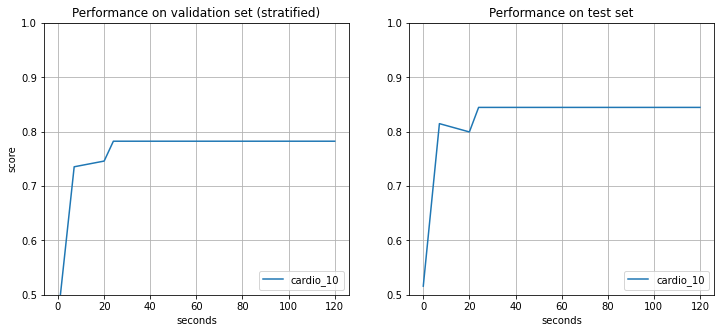

In [7]:
# Figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12,5))
#
# Plot validation performance
for d, results in valid_performance.items():
    # exctract series
    x1 = (results.Timestamp-results.Timestamp[0]).apply(td.total_seconds)
    y1 = results.single_best_optimization_score
    # modify for plotting
    x1.at[x1.shape[0]] = total_budget
    y1.at[y1.shape[0]] = y1.at[y1.shape[0]-1]
    ax1.plot(x1, y1)
ax1.legend(list(datasets.keys()), loc='lower right')
ax1.set_ylim([0.5, 1.])
ax1.set_xlabel('seconds')
ax1.set_ylabel('score')
ax1.set_title('Performance on validation set ({})'.format(validation_type))
ax1.grid()
#
# Plot test set performance
for d, results in test_performance.items():
    # exctract series
    x2 = (results.Timestamp-results.Timestamp[0]).apply(td.total_seconds)
    y2 = results.single_best_test_score
    # modify plotting
    x2.at[x2.shape[0]] = total_budget
    y2.at[y2.shape[0]] = y2.at[y2.shape[0]-1]
    ax2.plot(x2, y2)
ax2.legend(list(datasets.keys()), loc='lower right')
ax2.set_ylim([0.5, 1.])
ax2.set_xlabel('seconds')
#ax2.set_ylabel('score')
ax2.set_title('Performance on test set')
ax2.grid()

In [13]:
automl.

AutoSklearnClassifier(delete_tmp_folder_after_terminate=False, ensemble_size=0,
                      get_smac_object_callback=<function get_smac_object_callback.<locals>.get_smac_object at 0x7fd65c357d30>,
                      include={'classifier': ['CBLOFClassifier',
                                              'COPODClassifier',
                                              'IForestClassifier',
                                              'KNNClassifier',
                                              'LOFClassifier'],
                               'data_preprocessor': ['NoPreprocessing'],
                               'feature_preprocessor': ['no_preprocessing']},
                      initial_configurations_via_metalearning=0, metric=roc_auc,
                      per_run_time_limit=30,
                      resampling_strategy=PredefinedSplit(test_fold=array([-1, -1, ..., -1, -1])),
                      scoring_functions=[roc_auc, average_precision],
                      t